In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config
set_config(display='diagram')

In [82]:
filename = 'heart.csv'
df = pd.read_csv(filename)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [83]:
df.shape

(918, 12)

- Fuente de datos: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
- Breve descripción: Modelo de clasificación de ML para predecir si es que un paciente tendrá o no una enfermedad al corazón, utilizando características como edad, sexo, niveles de colesterol, tipo de dolor en el pecho, entre otras.
- ¿Cual es el objetivo?: Predecir si es que un paciente presentará una enfermedad al corazón o no.
- ¿Este es un problema de clasificación o regresión?: Clasificación.
- ¿Cuántas características hay?: 11 características.
- ¿Cuántas filas de datos hay?: 918 filas.
- ¿Qué retos, si es que hay alguno, prevén en la limpieza, exploración o modelización con este conjunto de datos?: A simple vista, se deben estandarizar los datos y además aplicar OHE.

In [84]:
#Verificación de filas duplicadas
df.duplicated().sum()

0

In [85]:
#Verificación de filas con valores NaN
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Diccionario del dataset:

- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [98]:
df['ExerciseAngina'].value_counts()

N    546
Y    371
Name: ExerciseAngina, dtype: int64

In [99]:
df['ExerciseAngina'].replace({'Y':1,'N':0}, inplace=True)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289.0,0,Normal,172,0,0.0,Up,0
1,49,F,NAP,160,180.0,0,Normal,156,0,1.0,Flat,1
2,37,M,ATA,130,283.0,0,ST,98,0,0.0,Up,0
3,48,F,ASY,138,214.0,0,Normal,108,1,1.5,Flat,1
4,54,M,NAP,150,195.0,0,Normal,122,0,0.0,Up,0


In [100]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,245.565666,0.233370,136.789531,0.404580,0.886696,0.552890
std,9.437636,17.999749,53.409819,0.423206,25.467129,0.491078,1.066960,0.497466
min,28.000000,80.000000,85.000000,0.000000,60.000000,0.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,250.000000,0.000000,138.000000,0.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.200000,1.000000


Nuestra columna objetivo es: "HeartDisease". Al parecer, se presenta una incongruencia en los datos de RestingBP y Cholesterol, donde el valor mínimo es 0, lo cual es imposible.

In [88]:
df.loc[df['RestingBP']==0,:]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


La fila donde RestingBP == 0 es solo una, por lo que decido eliminarla. Para el caso del colesterol, decido rellenar las filas con el valor promedio, dependiendo de si HeartDisease es 1 o 0.

In [89]:
#Elimino la fila donde RestinBP == 0
df = df.drop(449)

In [97]:
promedio1 = df.loc[(df['Cholesterol'] != 0) & (df['HeartDisease'] == 1), 'Cholesterol'].mean()
promedio0 = df.loc[(df['Cholesterol'] != 0) & (df['HeartDisease'] == 0), 'Cholesterol'].mean()
print(promedio1)
print(promedio0)

251.06179775280899
238.7692307692308


In [91]:
df.loc[(df['Cholesterol'] == 0) & (df['HeartDisease'] == 1), 'Cholesterol'] = promedio1
df.loc[(df['Cholesterol'] == 0) & (df['HeartDisease'] == 0), 'Cholesterol'] = promedio0

In [92]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,245.565666,0.233370,136.789531,0.886696,0.552890
std,9.437636,17.999749,53.409819,0.423206,25.467129,1.066960,0.497466
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,250.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Podemos apreciar que Cholesterol ya no tiene como valor mínimo 0, al igual que RestingBP

In [93]:
df['HeartDisease'].value_counts()

1    507
0    410
Name: HeartDisease, dtype: int64

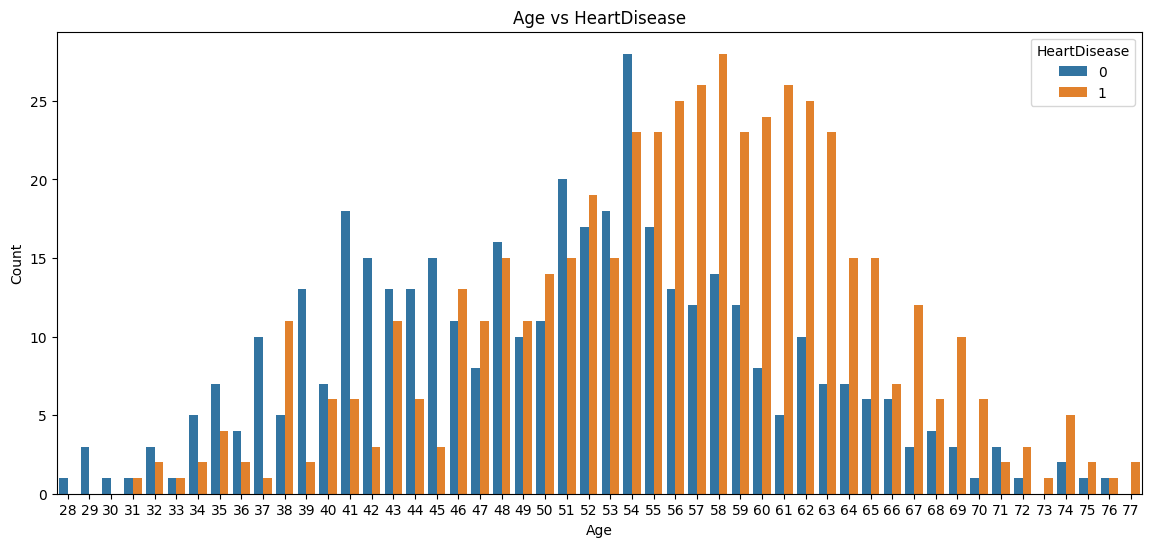

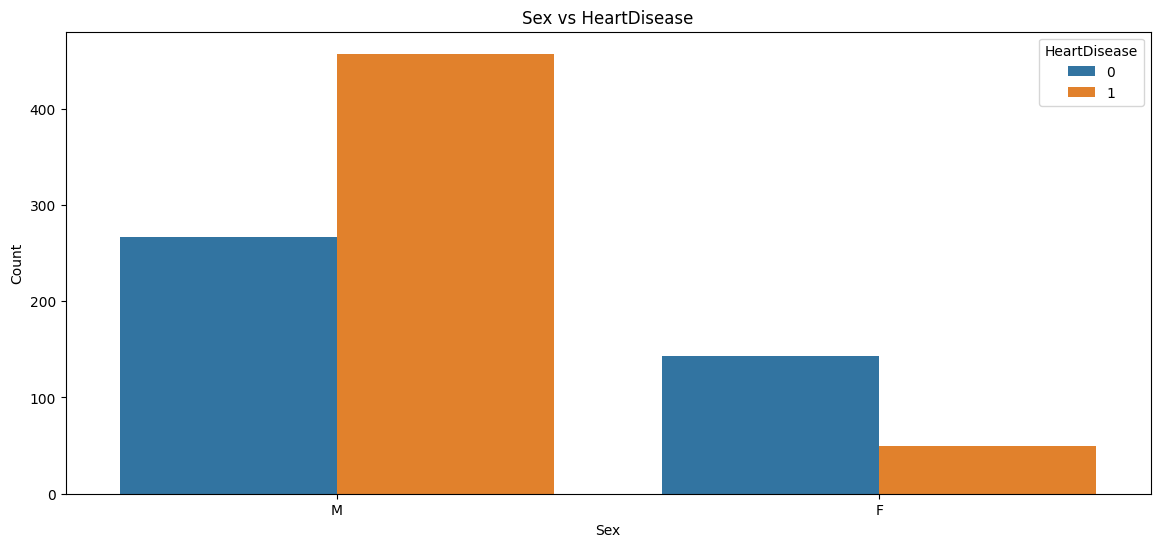

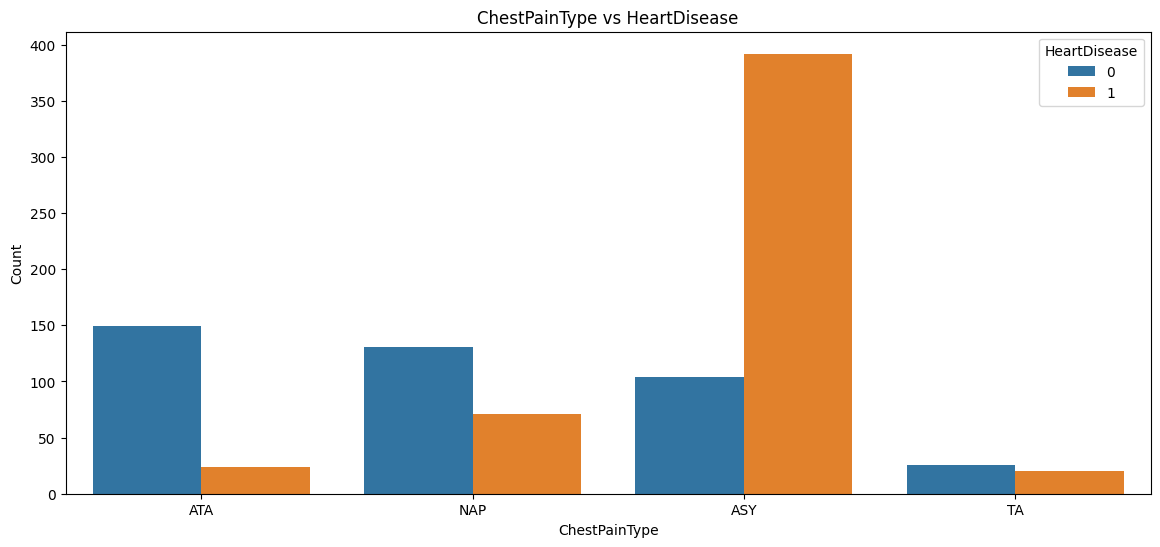

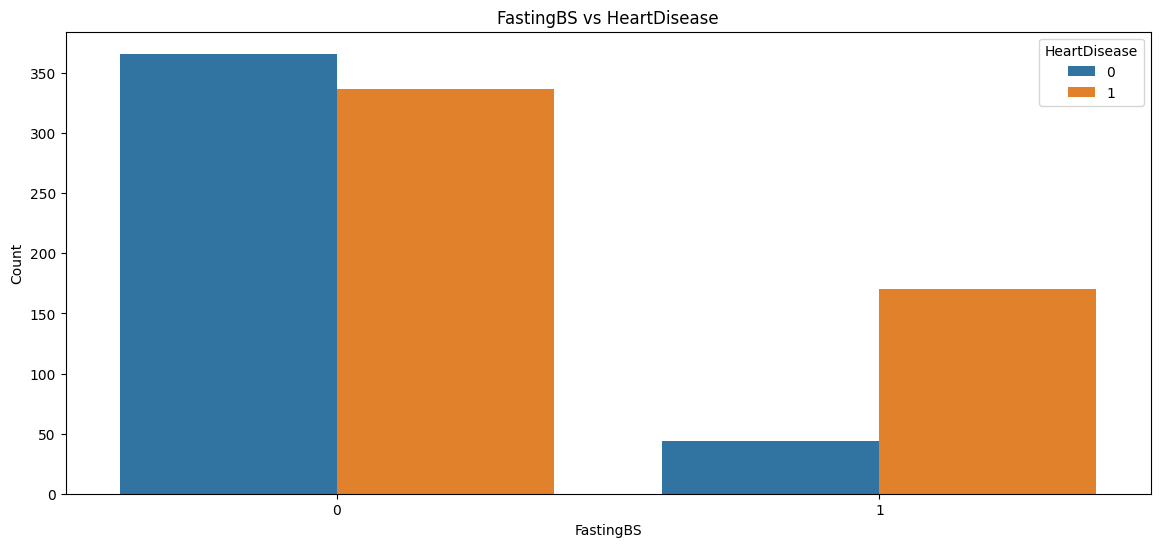

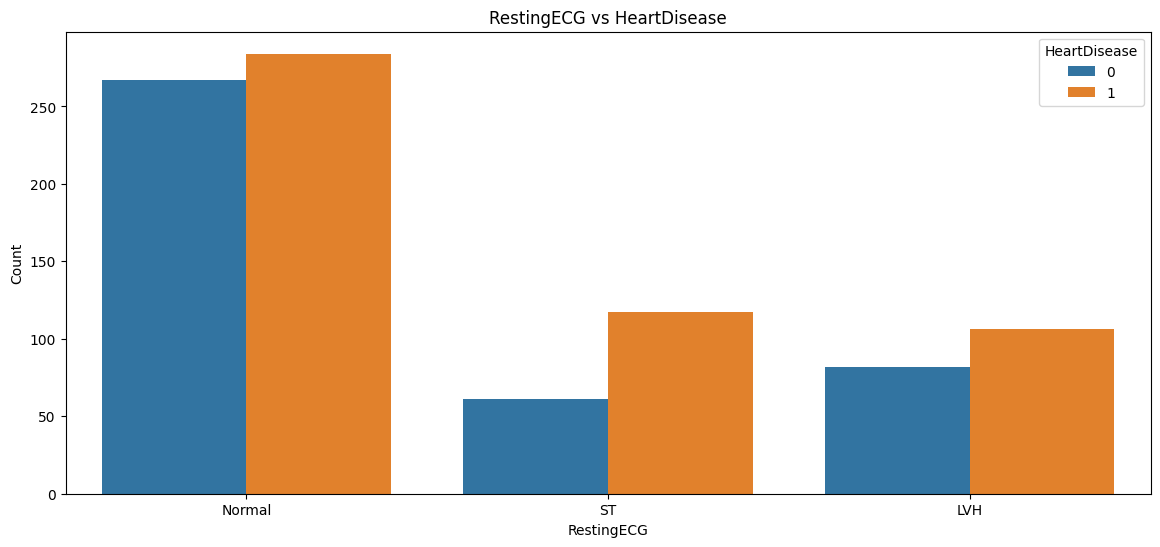

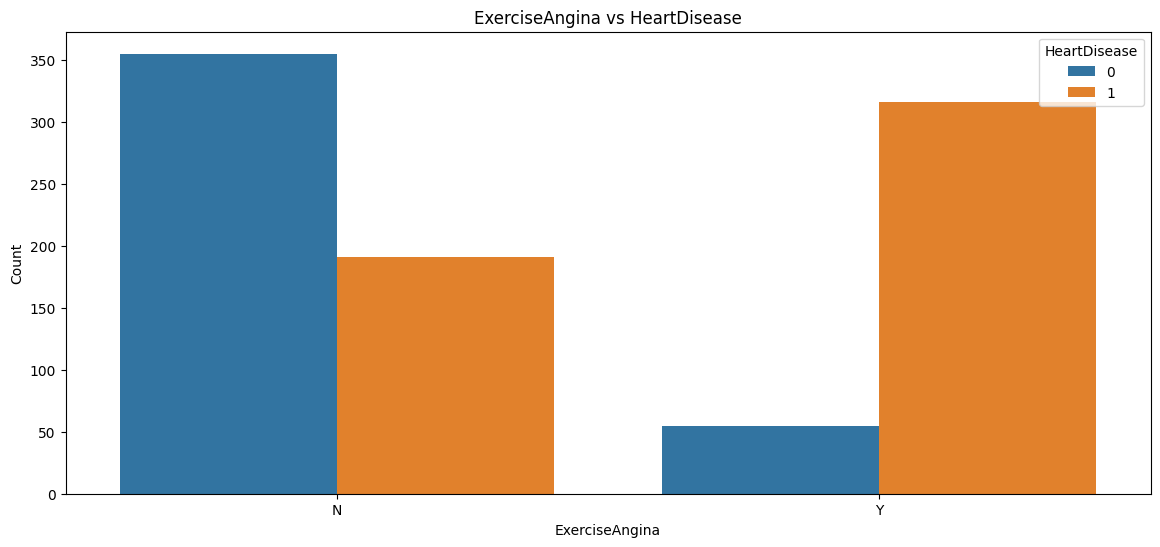

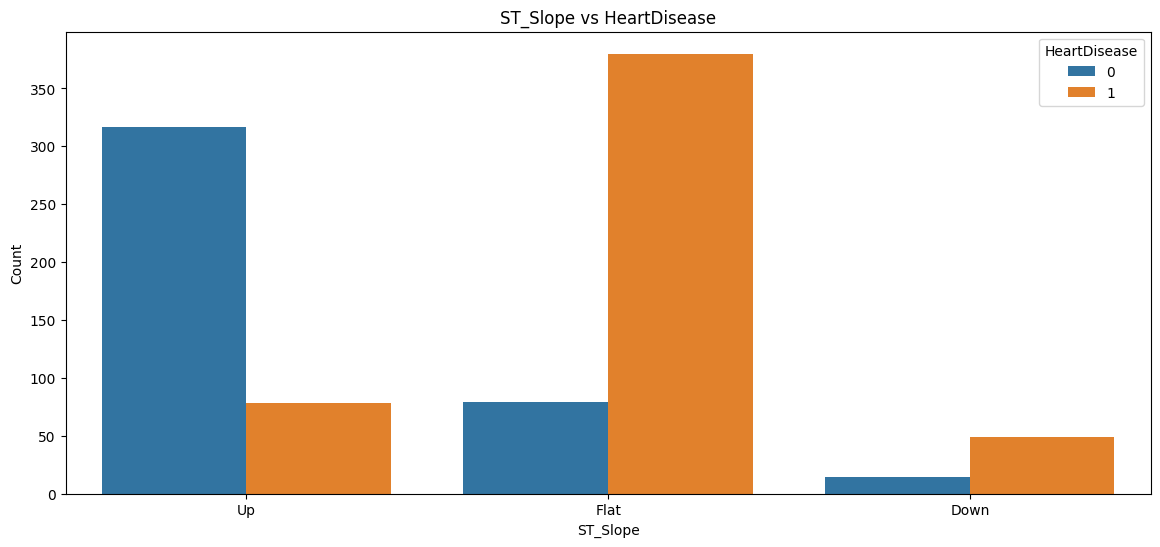

In [94]:
features = ['Age', 'Sex', 'ChestPainType', 'FastingBS',
            'RestingECG', 'ExerciseAngina', 'ST_Slope']

for feature in features:
    plt.figure(figsize=(14, 6))
    sns.countplot(x=feature, hue='HeartDisease', data=df)
    plt.title(f'{feature} vs HeartDisease')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='HeartDisease', loc='upper right')
    plt.show()

C:\Users\fabia\AppData\Local\Temp\ipykernel_13236\215740514.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


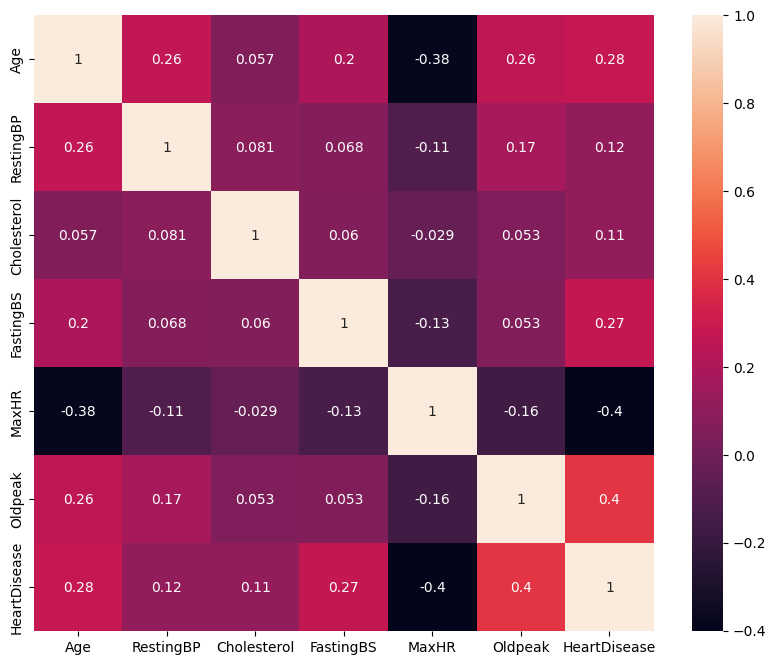

In [95]:
plt.figure(figsize=(10, 8))

sns.heatmap(df.corr(),annot=True)

plt.show()